<a href="https://colab.research.google.com/github/sheliak/klasifikacija_spektrov/blob/main/klasifikacija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija zvezdnih spektrov s strojnim učenjem

Delavnica za tabor Gimnazije Bežigrad, junij 2023

Seznam poglavij:

 - [Spoznajmo spektre](#spoznajmo-spektre)
 - [Metoda glavnih komponent](#pca)
 - [Nelinearne projekcije](#tsne)



In [78]:
# Ta del kode naloži nekaj knjižnic (standardnih programov), na primer za
# risanje grafov (matplotlib) in za numerične operacije in funkcije (numpy) in
# nastavi nekaj parametrov.
# Na tak način se začne tipičen računalniški program, s čimer se danes ne bomo
# ukvarjali.
%matplotlib inline
from ipywidgets import interactive, Label, Layout, FloatSlider, Dropdown
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
from IPython.display import Audio, Markdown, display
from astropy.io import fits
import urllib.request


<a id='spoznajmo spektre'></a>
## Spoznajmo spektre zvezd

### Kaj je spekter

### Spektri zvezd

### Narišimo spekter

Za to vajo imamo na voljo spektre 10 000 različnih zvezd, ki jih je posnel pregled neba GALAH. Na voljo nam je del spektra z valovnimi dolžinami med 655.0 nm in 667.5 nm. Za 52 od teh zvezd imamo podane tudi podatke o temperaturi zvezde, gravitacijskem pospešku na njenem površju in zastopanost kovin v zvezdini atmosferi. Za ostale zvezde so ti parametri še neznani. Za 56 zvezd imamo podane njihove tipe (glej sledečo tabelo). Za ostale zvezde prav tako ne vemo kakšnih tipov so.

| Kratica | Tip zvezde | Lastnost |
| --- | --- | --- |
| MAB | Zvezde z molekularnimi črtami | V hladnejših zvezdah lahko preživijo preproste molekule, kot sta TiO in CN. te vidimo kot široke serije absorpcijskih črt ali pasov. |
| BIN | Dvojne zvezde | Zajeli smo svetlobo dveh zvezd in zato vidimo seštevek spektrov dveh zvezd. |
| TRI | Trojne zvezde | Vidimo seštevek treh spektrov treh zvezd. Posamezne zvezde so lahko različnih tipov. |
| HFR | Vroče, hitro se vrteče zvezde | Spektralne črte so močno razširjene. Šibkejših črt zato ne vidimo.|
| HAE | Spektri z emisijo v vodikovi H alpha črti. | Namesto absorpcijske črte vidimo emisijsko črto pri okoli 656 nm. Ali pa kombinacijo emisijske in absorpcijske črte.  |
| CMP | Hladne zvezde z malo kovinami | Absorpcijske črte kovin so šibke. Prav tako vodikova črta, saj so te zvezde hladne.|
| DIB | Prisotnost medzvezdnih absorpcijskih črt | Plin v prostoru med nami in zvezdo je dodal svoje absorpcijske črte, na primer okoli 661 nm. |

Za nekaj zvezd z znanimi tipi ali parametri narišimo njihov spekter. Številka spektra z znanim tipom ali parametri je podana v prvem stolpcu datotek `ucni_set_tipi.txt` in `ucni_set_parametri.txt`.

(6550.0, 6674.98)

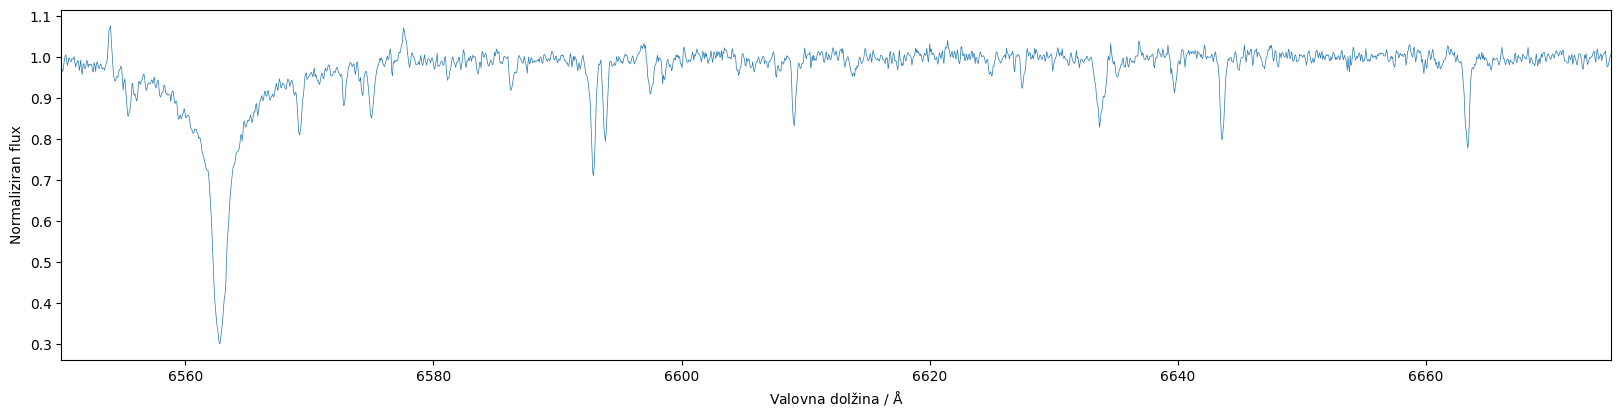

In [79]:
# Naredimo slovar tipov

tipi={}
for line in urllib.request.urlopen('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/ucni_set_tipi.txt'):
    line=line.decode('utf-8')
    if line[0]=='#': continue
    spekter, tip = line.split()
    if tip in tipi:
        tipi[tip].append(spekter)
    else:
        tipi[tip]=[spekter]

# Narisimo spekter nekega tipa ('MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB')

spekter=tipi['BIN'][0]
l=np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/val.dat') # seznam valovnih dolzin
w = np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/%s.dat' % spekter) # flux

fig=plt.figure(0)
ax=fig.add_subplot(211)
ax.plot(l,w,lw=0.5)
ax.set_xlabel('Valovna dolžina / $\mathrm{\AA}$')
ax.set_ylabel('Normaliziran flux')
ax.set_xlim(l[0], l[-1])

In [82]:


# Narisimo vse spektre nekega tipa

menu = Dropdown(options=['MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB'], value='MAB', description='Tip:')
display(menu)


def plot_all(spekter_bold=0):
    fig=plt.figure(0)
    ax=fig.add_subplot(212)

    tip=menu.value

    spectra=[]
    for spekter in tipi[tip]:
        w = np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/%s.dat' % spekter)
        spectra.append(w)
        ax.plot(l,w,lw=0.6, alpha=0.2, c='k')
    ax.plot(l,spectra[spekter_bold], lw=0.6, alpha=1, c='r')
    ax.set_xlabel('Valovna dolžina / $\mathrm{\AA}$')
    ax.set_ylabel('Normaliziran flux')
    ax.set_title('Spekter # '+tipi[tip][spekter_bold])
    ax.set_xlim(l[0], l[-1])
    plt.show()


w=interactive(plot_all, spekter_bold=(0,len(tipi['BIN'])-1,1))
w


Dropdown(description='Tip:', options=('MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB'), value='MAB')

interactive(children=(IntSlider(value=0, description='spekter_bold', max=7), Output()), _dom_classes=('widget-…

Vidimo, da v večini primerov brez učnega seta sploh ne moremo ugotoviti, kakšnega tipa so te zvezde. Na primer, večina dvojnih zvezd nima podvojenih črt. Vidimo le eno od komponent, ali pa so črte primarne in sekundarne zvezde zlite skupaj.

Katerega tipa so zvezde bo veliko bolje od naših uči ugotovil računalnik.